In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal, interpolate
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

from data_loader import load_pickle, unpack_data
sns.set()

N_SUBJECTS = 10

In [2]:
datasets = []
for i in range(1, N_SUBJECTS + 1):
    datasets.append(load_pickle(i))

In [3]:
def aggregate_bins(Sxx, num_bins):
    Sxx_new = np.zeros((math.ceil(Sxx.shape[0] / num_bins), Sxx.shape[1]))
    for idx, row in enumerate(Sxx):
        Sxx_new[idx // num_bins, :] += row
    return Sxx_new / num_bins

In [4]:
def regression_score(X, y):
    reg = LinearRegression().fit(X, y)
    return reg.score(X, y)

<ipython-input-5-61d9a638d7ac>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


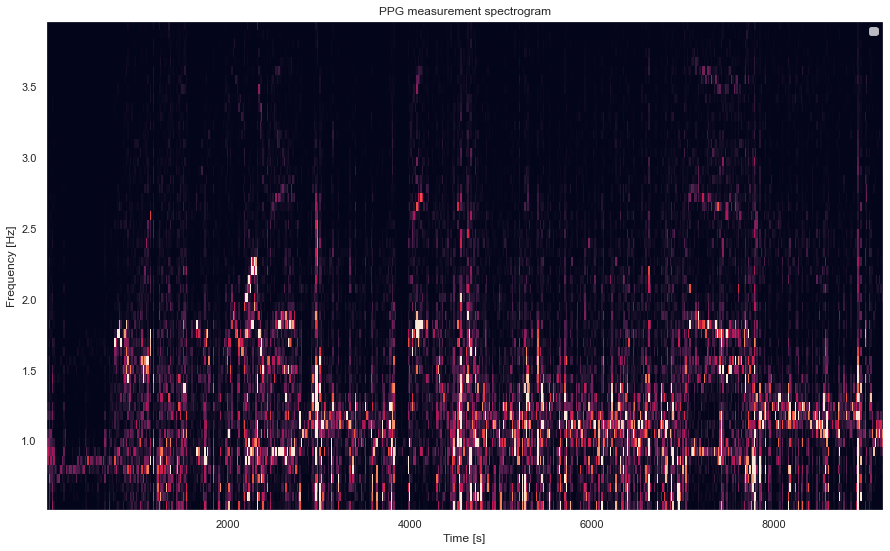

<ipython-input-5-61d9a638d7ac>:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg[::num_bin_aggregation], Sxx_new, shading='flat')


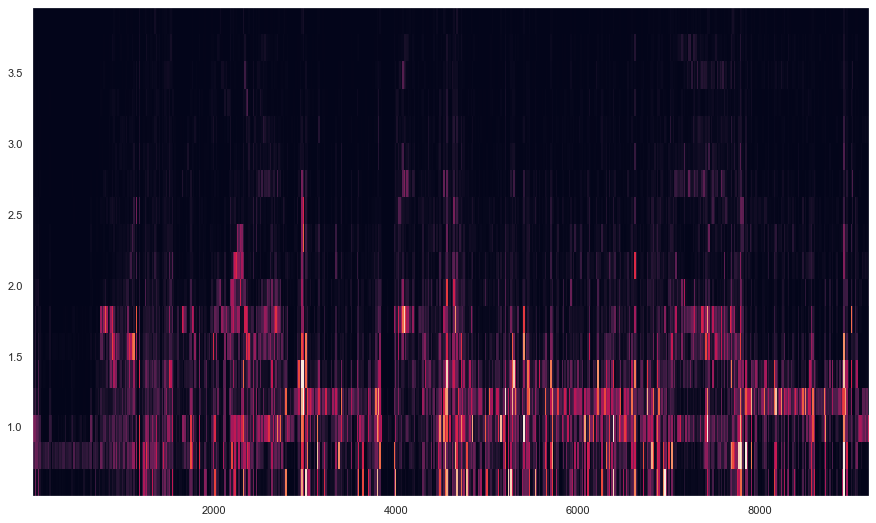

<ipython-input-5-61d9a638d7ac>:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_clipped, shading='flat')
No handles with labels found to put in legend.


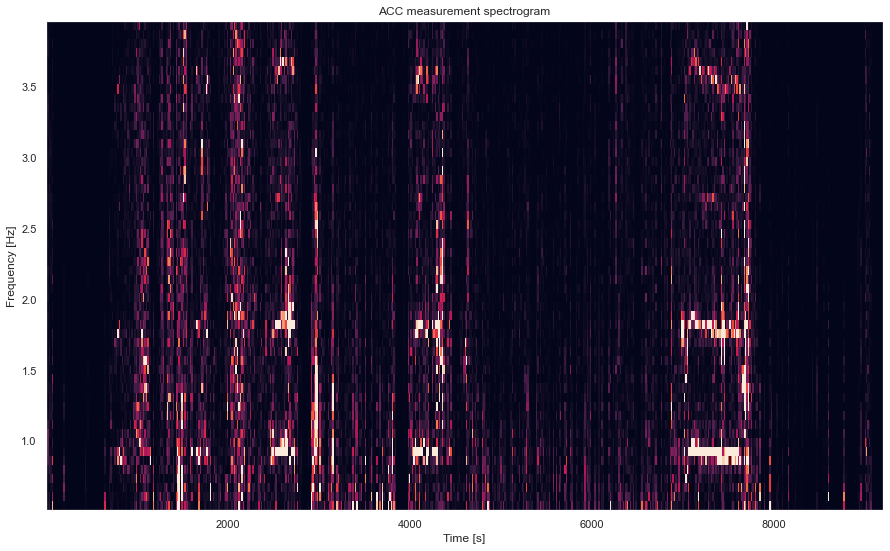

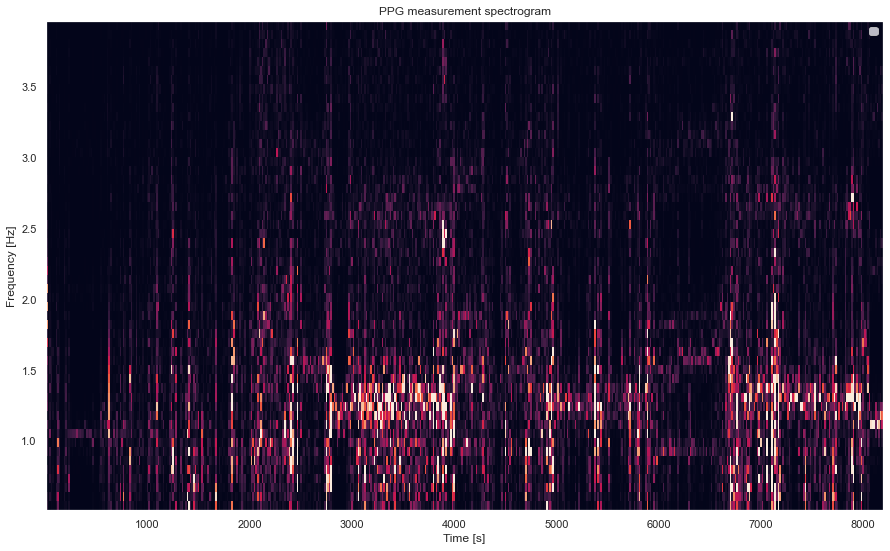

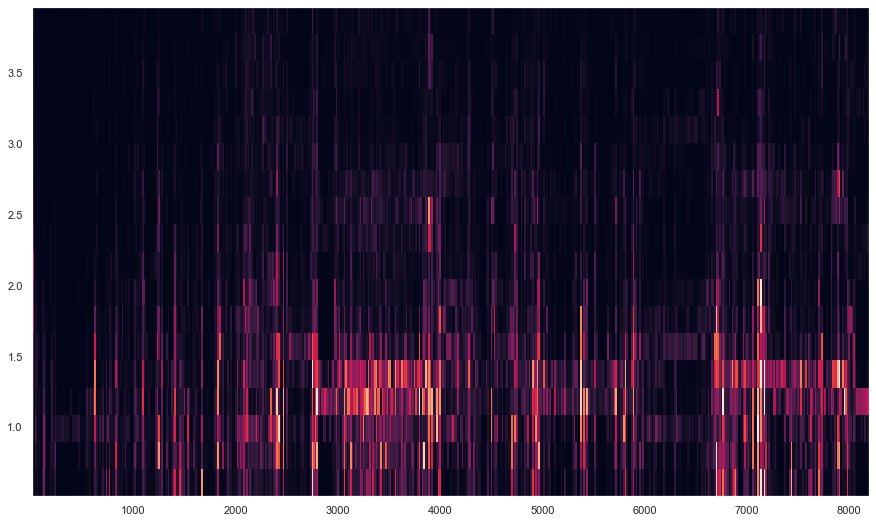

No handles with labels found to put in legend.


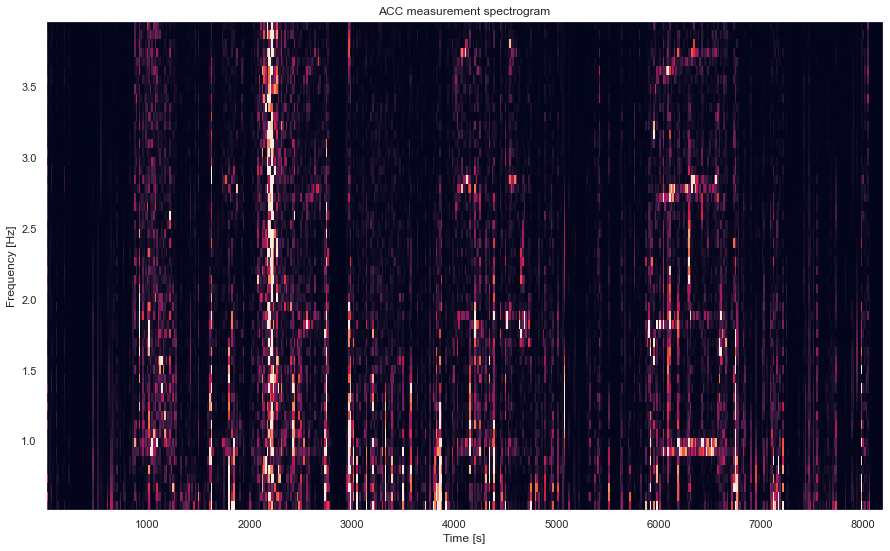

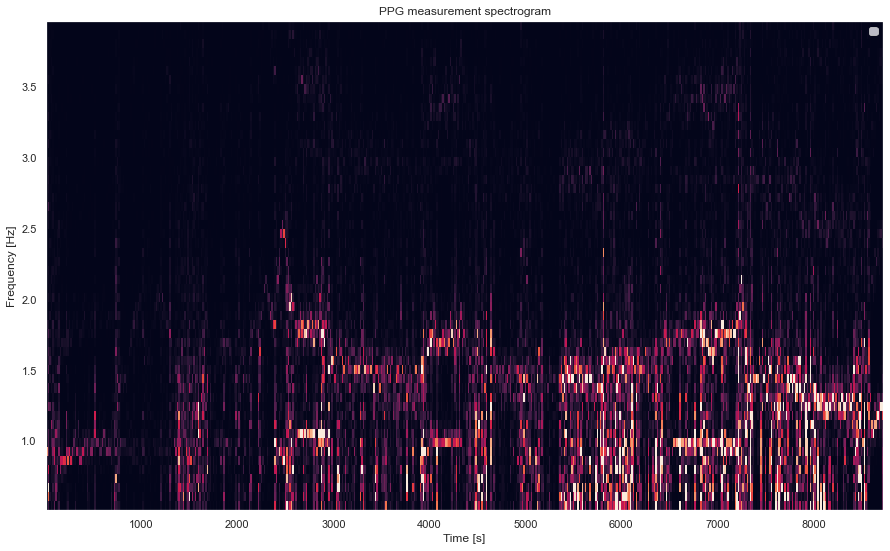

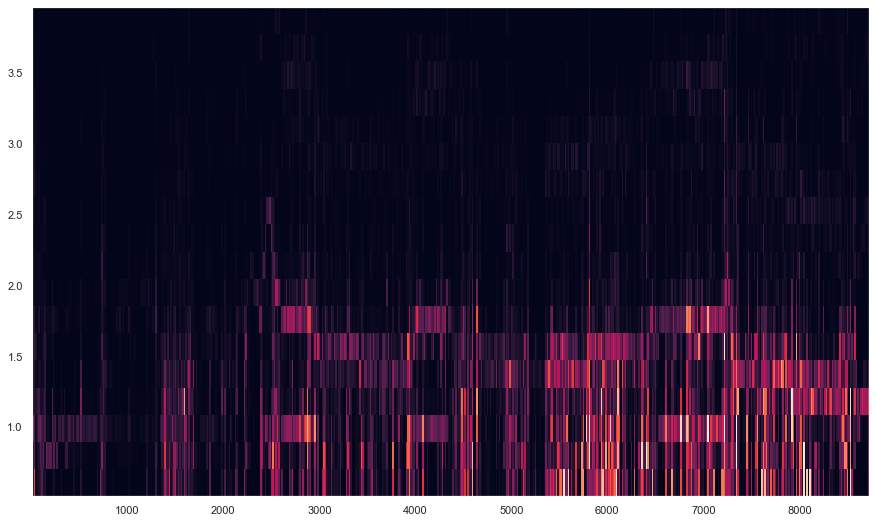

No handles with labels found to put in legend.


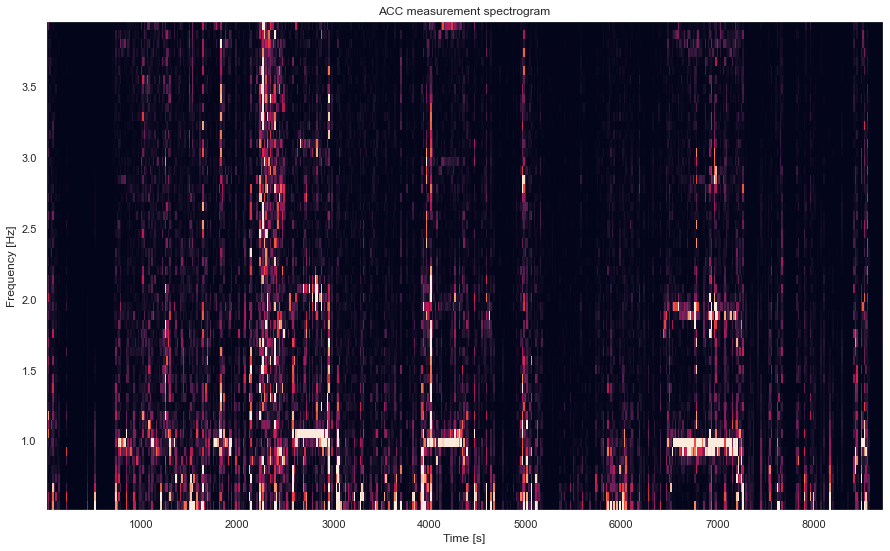

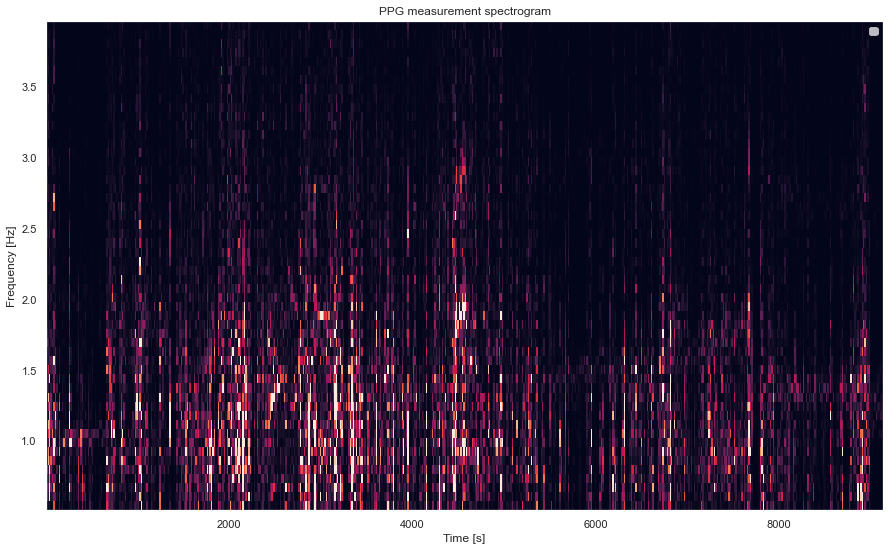

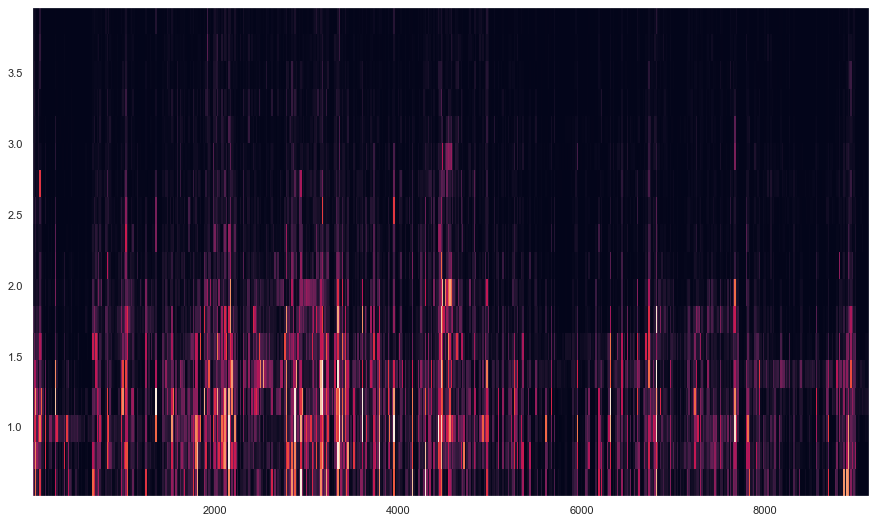

No handles with labels found to put in legend.


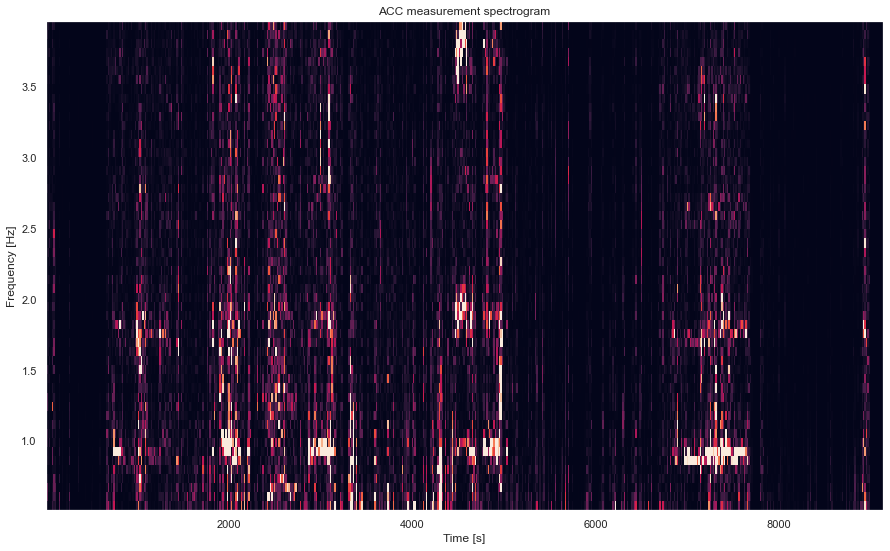

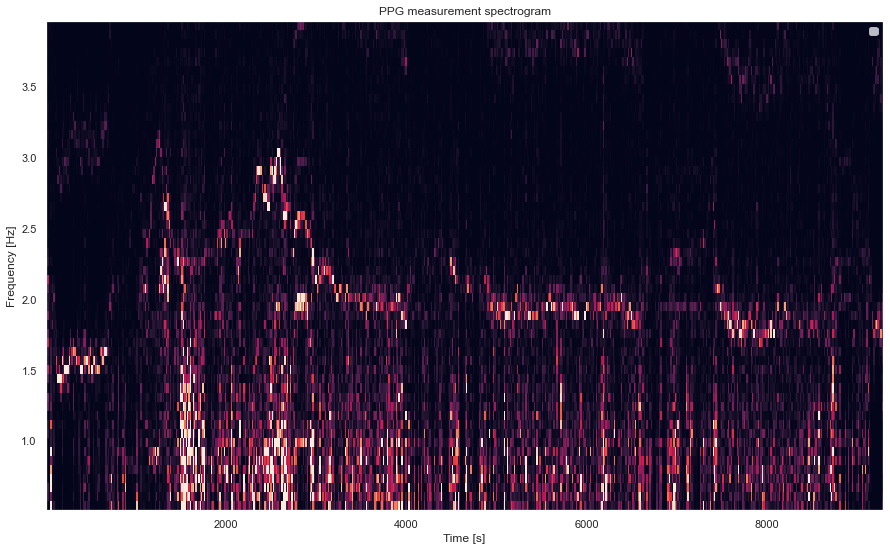

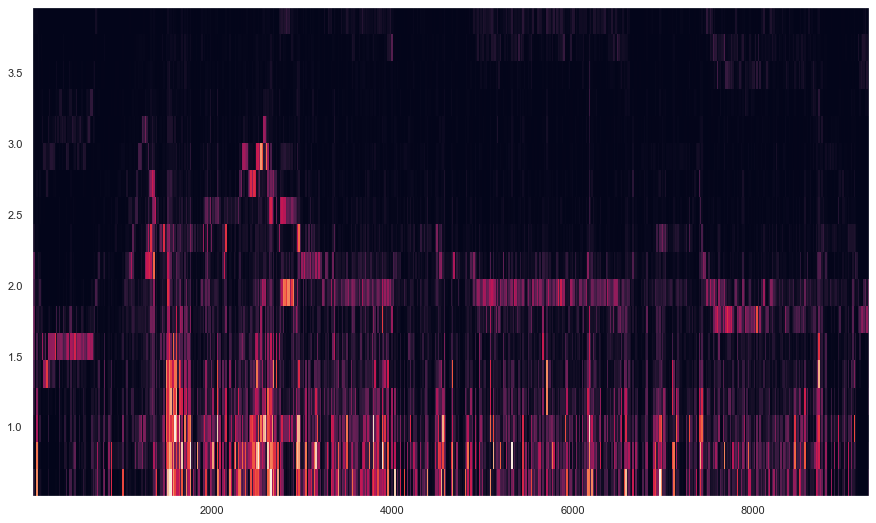

No handles with labels found to put in legend.


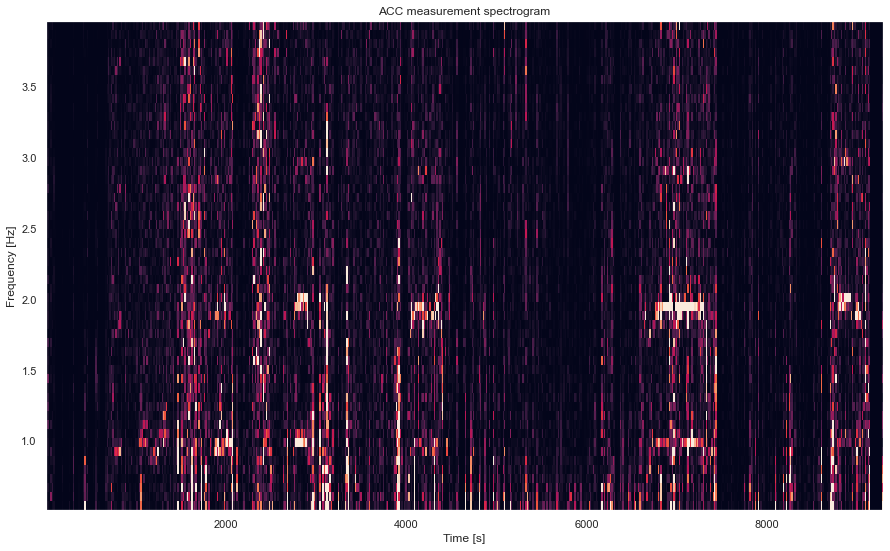

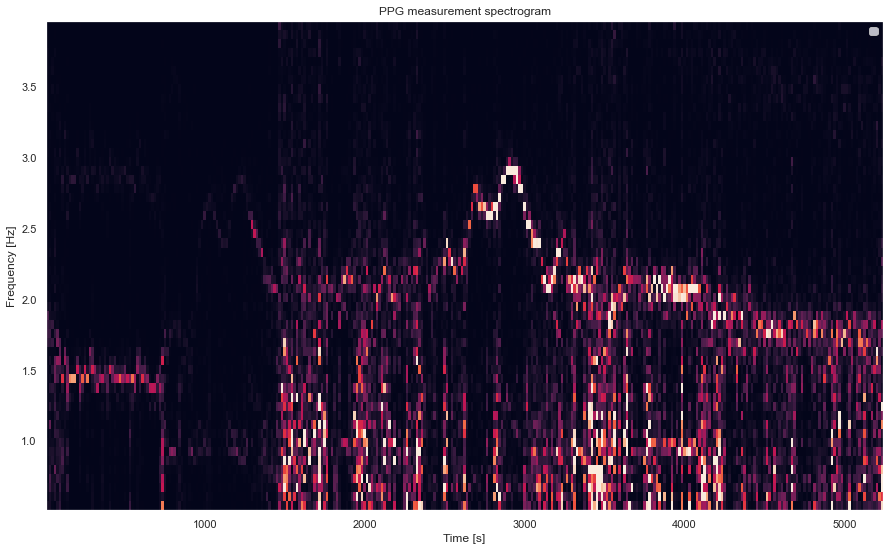

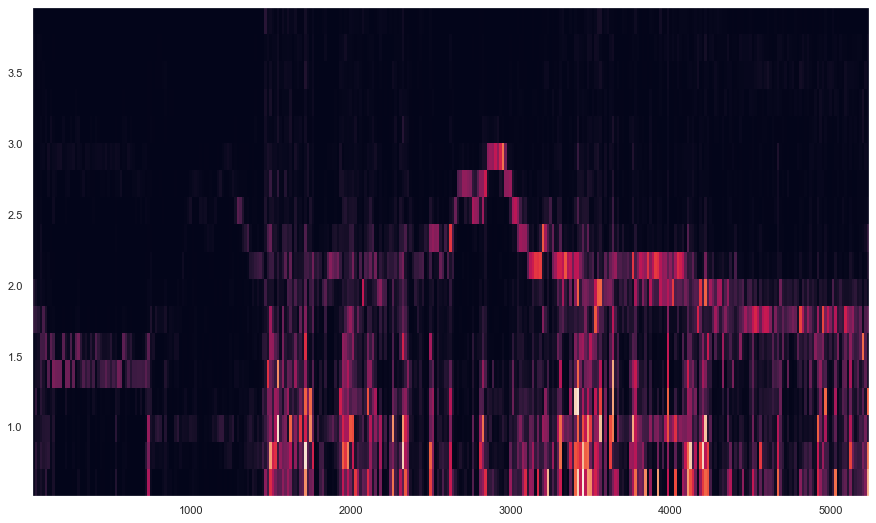

No handles with labels found to put in legend.


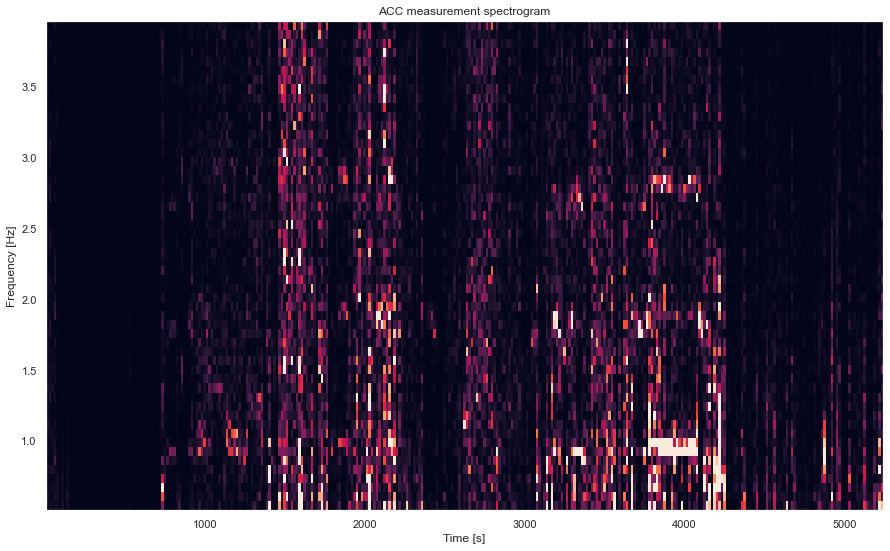

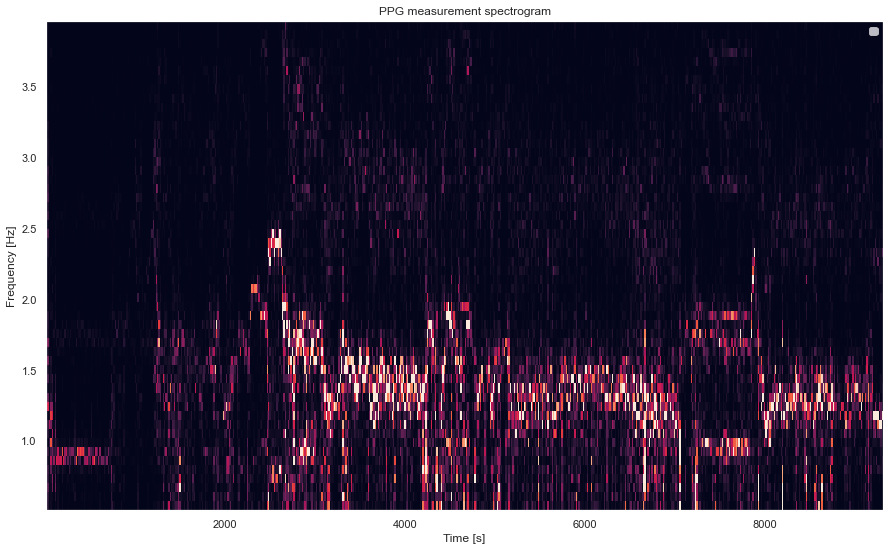

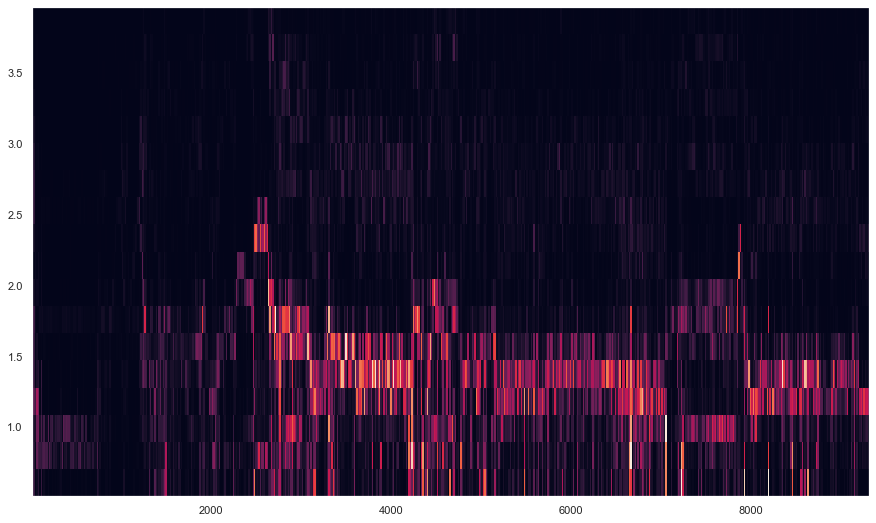

No handles with labels found to put in legend.


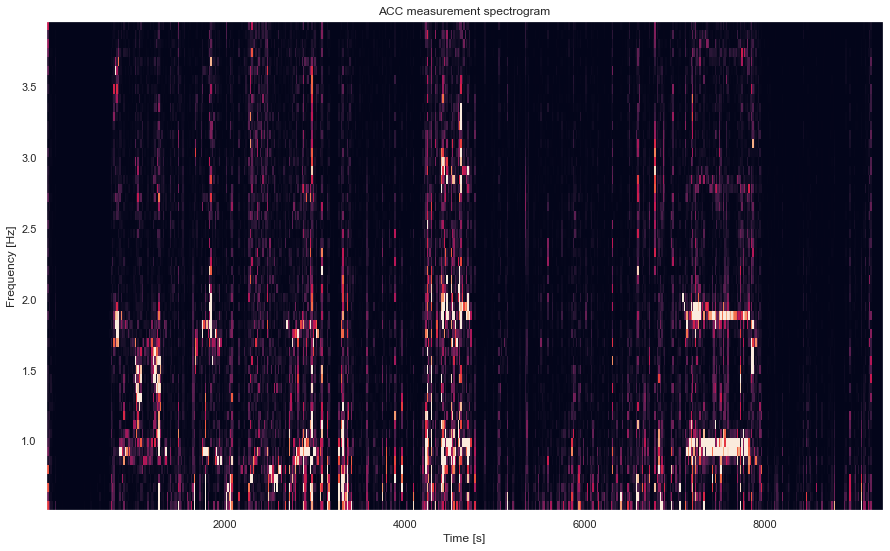

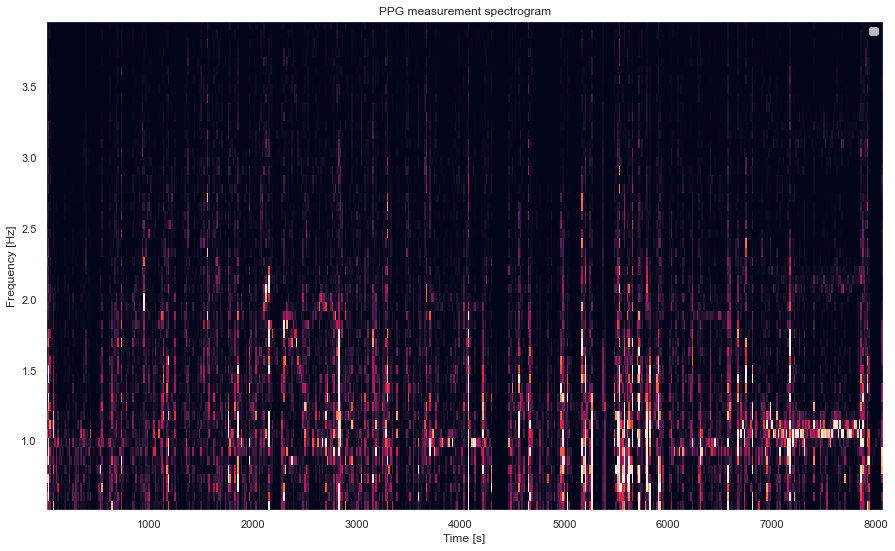

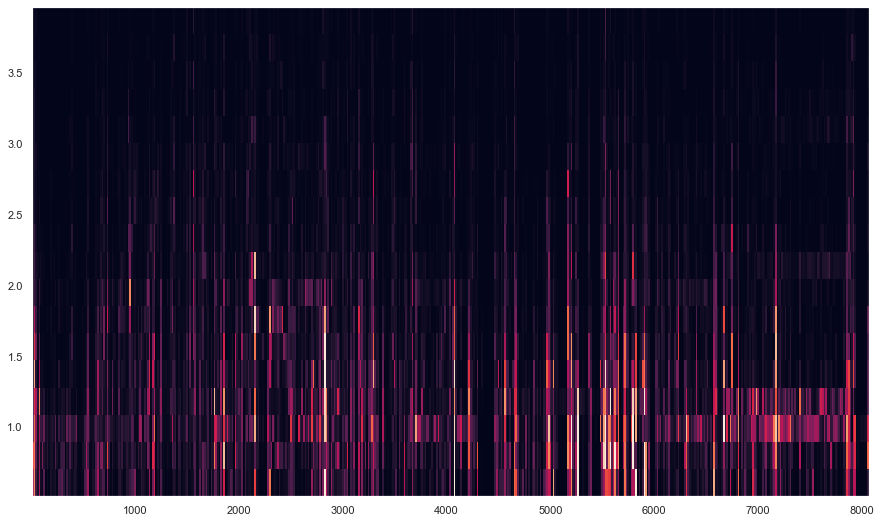

No handles with labels found to put in legend.


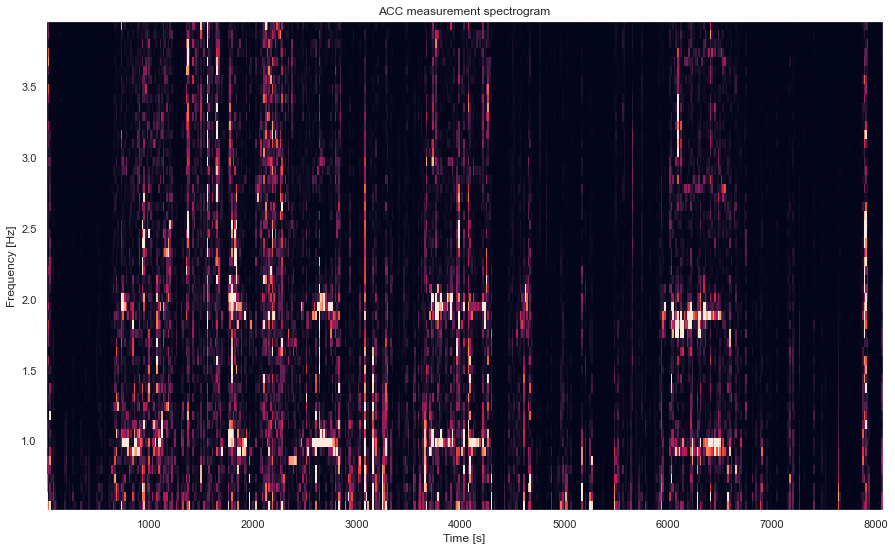

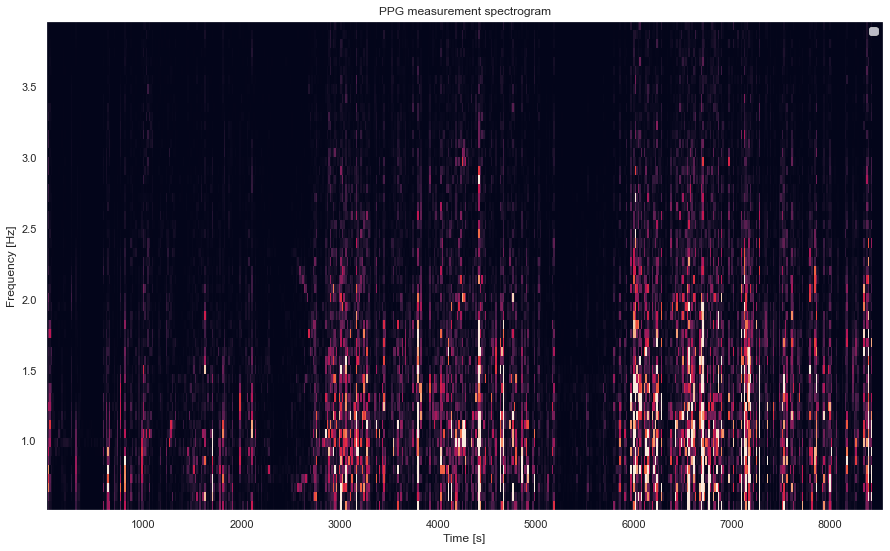

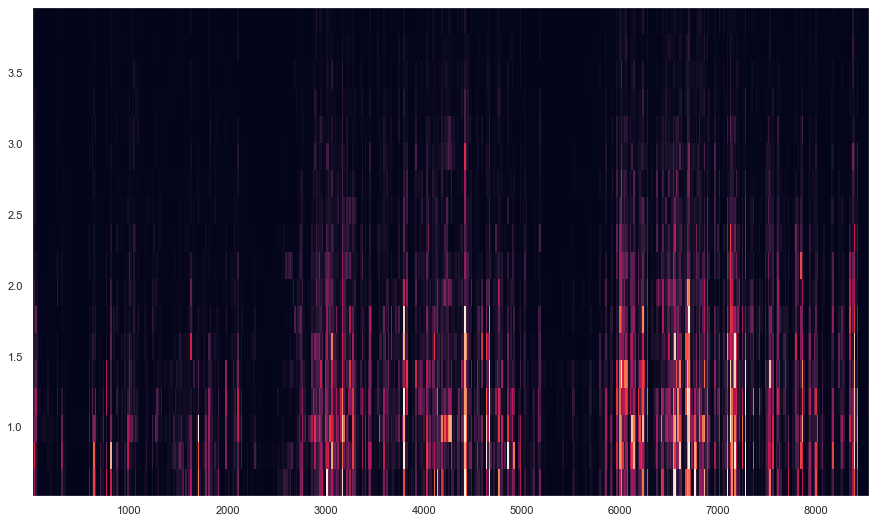

No handles with labels found to put in legend.


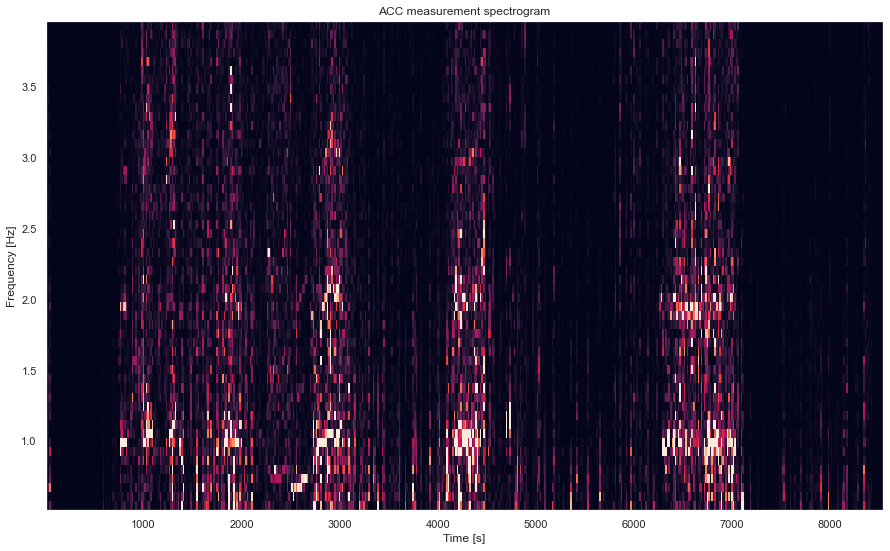

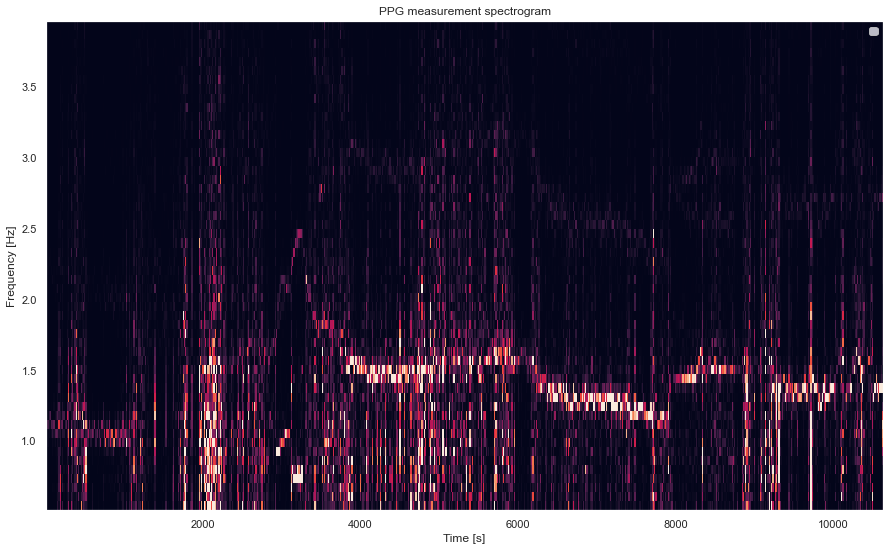

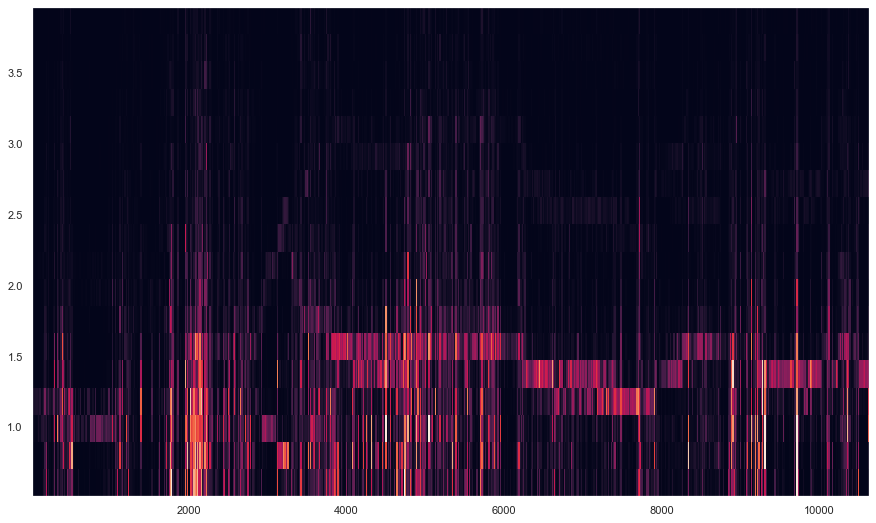

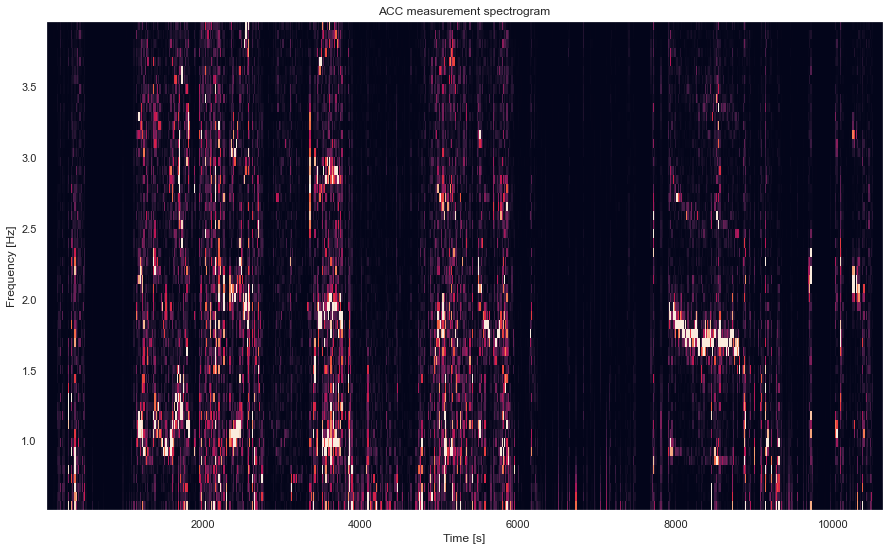

In [5]:
acc_threshold_percentile = 95
distances_default_value = 1

fs_ppg = 64
fs_acc = 32
nperseg_ppg = 1000
nperseg_acc = 500
noverlap = 0

num_bin_aggregation = 3

distances_list = []
activity_list = []

for dataset in datasets:

    ppg, acc, hr, activity, _= unpack_data(dataset)

    hr_timestamps = np.arange(0, len(hr) * 2, 2)
    hr_interpolation = interpolate.interp1d(hr_timestamps, hr)
    
    ### create spectrograms
    f_ppg, t_ppg, Sxx_ppg = signal.spectrogram(ppg, fs_ppg, nperseg=nperseg_ppg, noverlap=noverlap)
    f_acc, t_acc, Sxx_acc = signal.spectrogram(acc, fs_acc, nperseg=nperseg_acc, noverlap=noverlap)
    
    ### keep only frequencies of interest
    fmin = 0.5 # Hz
    fmax = 4 # Hz
    freq_slice_ppg = np.where((f_ppg >= fmin) & (f_ppg <= fmax))
    freq_slice_acc = np.where((f_acc >= fmin) & (f_acc <= fmax))
    f_ppg = f_ppg[freq_slice_ppg]
    f_acc = f_acc[freq_slice_acc]
    Sxx_ppg = Sxx_ppg[freq_slice_ppg,:][0]
    Sxx_acc = Sxx_acc[freq_slice_acc,:][0]
    
    ### clip spectrograms
    Sxx_acc_clipped = np.clip(Sxx_acc, 0, np.percentile(Sxx_acc.flatten(), 99))
    Sxx_ppg_clipped = np.clip(Sxx_ppg, 0, np.percentile(Sxx_ppg.flatten(), 99))

    ### plot ppg spectrogram
    plt.figure(figsize=(15, 9))
    plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
    plt.title('PPG measurement spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    
    ### plot heart rate
    ppg_estimate = f_ppg[np.argmax(Sxx_ppg, axis=0)]
    #plt.plot(hr_timestamps, hr, 'g--', label='heart rate')
    #plt.plot(t_ppg, ppg_estimate, 'g--', label='ppg heart rate estimate')
    plt.legend()
    plt.show()
    
    ### plot reduced ppg spectrogram
    plt.figure(figsize=(15, 9))
    Sxx_new = aggregate_bins(Sxx_ppg_clipped, num_bin_aggregation)
    plt.pcolormesh(t_ppg, f_ppg[::num_bin_aggregation], Sxx_new, shading='flat')
    plt.show()
    
    
    ### plot acc spectrogram
    plt.figure(figsize=(15, 9))
    plt.pcolormesh(t_acc, f_acc, Sxx_acc_clipped, shading='flat')
    plt.title('ACC measurement spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')

Text(0.5, 1.0, 'Performance of linear HR regression on different frequency resolutions')

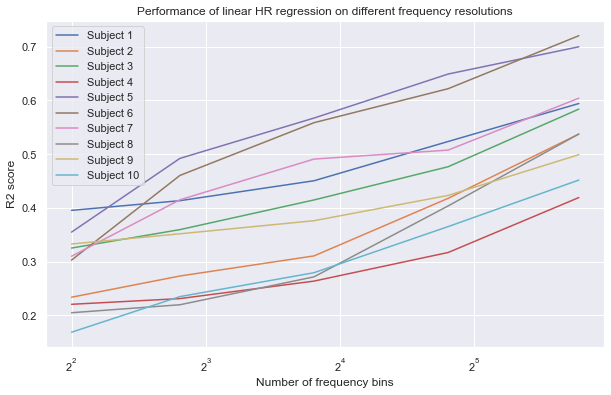

In [6]:

fig, ax=plt.subplots(figsize=(10, 6))

include_acc = True

ax.set_xscale("log", base=2)

for subject_idx, dataset in enumerate(datasets):

    ppg, acc, hr, activity, _= unpack_data(dataset)

    hr_timestamps = np.arange(1, len(hr) * 2, 2)
    hr_interpolation = interpolate.interp1d(hr_timestamps, hr)
    
    ### create spectrograms
    f_ppg, t_ppg, Sxx_ppg = signal.spectrogram(ppg, fs_ppg, nperseg=nperseg_ppg, noverlap=noverlap)
    f_acc, t_acc, Sxx_acc = signal.spectrogram(acc, fs_acc, nperseg=nperseg_acc, noverlap=noverlap)
    
    ### keep only frequencies of interest
    fmin = 0.5 # Hz
    fmax = 4 # Hz
    freq_slice_ppg = np.where((f_ppg >= fmin) & (f_ppg <= fmax))
    freq_slice_acc = np.where((f_acc >= fmin) & (f_acc <= fmax))
    f_ppg = f_ppg[freq_slice_ppg]
    f_acc = f_acc[freq_slice_acc]
    Sxx_ppg = Sxx_ppg[freq_slice_ppg,:][0]
    Sxx_acc = Sxx_acc[freq_slice_acc,:][0]
    
    ### clip spectrograms
    Sxx_acc_clipped = np.clip(Sxx_acc, 0, np.percentile(Sxx_acc.flatten(), 99))
    Sxx_ppg_clipped = np.clip(Sxx_ppg, 0, np.percentile(Sxx_ppg.flatten(), 99))
    
    scores = []
    num_bins = []
    max_aggregation = 10
    num_bin_aggregation_values = [1, 2, 4, 8, 16]
    
    
    for num_bin_aggregation in num_bin_aggregation_values:
        Sxx_ppg_new = aggregate_bins(Sxx_ppg, num_bin_aggregation)
        Sxx_acc_new = aggregate_bins(Sxx_acc, num_bin_aggregation)

        ### evaluate linear regression
        X = np.transpose(Sxx_ppg_new)
        if include_acc:
            X = np.concatenate([X, np.transpose(Sxx_acc_new)], axis=1)
        y = hr_interpolation(t_ppg)
        score = regression_score(X, y)
        scores.append(score)
        num_bins.append(Sxx_ppg_new.shape[0])

    ax.plot(num_bins, scores, label='Subject ' + str(subject_idx + 1))


ax.legend()
plt.xlabel('Number of frequency bins')
plt.ylabel('R2 score')
plt.title('Performance of linear HR regression on different frequency resolutions')

In [7]:
# TODO: select top k frequencies, regardless of where they lie using feature selection (correlation or mutual information)
# https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection